## Goal of this notebook

*'Most companies don’t care about the fancy ML metrics. They don’t care about increasing a model’s accuracy from 94% to 94.2% unless it moves some business metrics.' - [Chip Huyen, Designing Machine Learning Systems](https://www.oreilly.com/library/view/designing-machine-learning/9781098107956/)*

Chip Huyen (among many other practitioners) highlights that ML models hold value only when they drive meaningful benefits for the business. The goal of this notebook is to encourage you to develop a model with a focus on enhancing a relevant business metric, rather than just optimizing traditional ML metrics.

## Problem Setting

If you are an adult, chances are you have heard about credit scores (or FICO scores). Credit scores are a numerical representation of an individual's creditworthiness. They are used by lenders to assess how likely someone is to repay borrowed money or manage financial responsibilities. A credit score, usually ranging from 300 to 850, is based on various factors, including payment history, total debt, length of credit history, types of credit accounts, and recent credit inquiries. Higher scores typically indicate lower risk, making it easier to secure loans, credit cards, or favorable interest rates. Conversely, lower scores can make credit access challenging and more expensive.

Experian is one of the most famous and reliable provider of these FICO scores, and banks typically purchase these scores to assess the credit risk of potential borrowers and make lending decisions.

Imagine we are a seasoned bank with lots of data on our customers and a big loan portfolio. A stakeholder comes to you and says that given the bank needs to cut costs. Given the bank's long history and data availability, the stakeholder believes that we can cut costs by not purchasing FICO scores from providers but calculate them ourselves.

In the provided dataset there is information about 7500 loans, each with information about the borrower, the loan, and the respective FICO score which we have from Experian. We will assume that the FICO scores are the actual truth (for transparency - I generated them using a custom PD model. If you want to learn how to do that check the Udemy course below). Given that information, the stakeholder would like you to create a model that estimates the FICO scores with the least difference between your model's output and the actual FICO scores.

The stakeholder would also like to know how the bank's expecte loss will be affected in case your model's FICO scores differ from the original FICO scores. Don't worry, help on calculating this will be provided. 

*If you want to learn more about credit risk modelling, I recommend this course on [Udemy](https://www.udemy.com/course/credit-risk-modeling-in-python/)*

Here is a guide on how to think about different FICO scores:

https://www.beyondfinance.com/blog/wp-content/uploads/2021/09/FICO-score-range.png

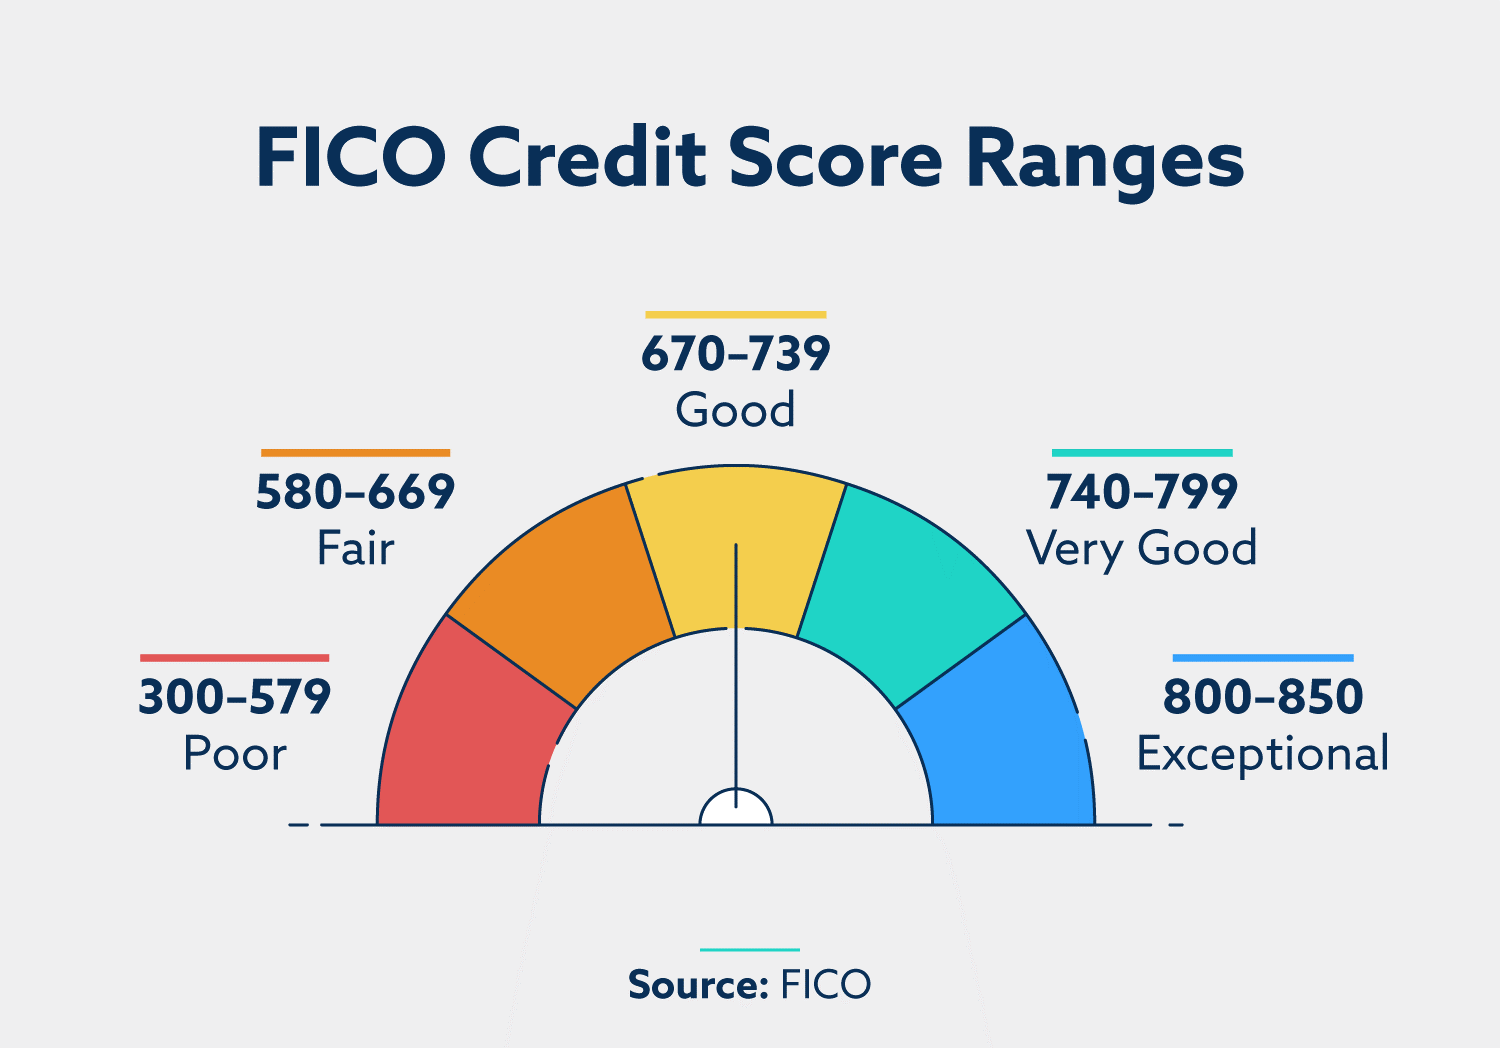

In [ ]:
# Default libraries you might need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Firstly, we will check the internal FICO model

### Load the data from HuggingFace

In [ ]:
df = pd.read_csv('https://huggingface.co/datasets/divakaivan/loan_data_for_exercise/resolve/main/loan_data.csv?download=true')

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,good_bad,FICO Score
0,5000,5000,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,...,False,False,False,False,False,False,False,False,1,610.0


### FICO scores exploration

**What is the distribution of FICO scores?**

a) Heavily scewed towards 'Poor' loans
b) Roughly normally distributed
c) Heavily scewed towards 'Exceptional' loans

**What is the mean FICO score?**

a) 501
b) 757
c) 608

In [176]:
df['FICO Score'].describe()

count    7500.000000
mean      608.853067
std        64.008861
min       378.000000
25%       567.000000
50%       616.000000
75%       655.000000
max       776.000000
Name: FICO Score, dtype: float64

**How much loans do we have in each FICO score range?**

Later we will compare these counts to the model's predictions so that we can present them to the stakeholder.

*Tip: Refer to the image chart above for the FICO ranges. You might want to use `pd.cut` for binning*

In [117]:
df['FICO_true_range'] = pd.cut(df['FICO Score'], bins=[300, 579, 669, 739, 799, 850], labels=['Poor (300-579)', 'Fair (580-669)', 'Good (670-739)', 'Very Good (740-799)', 'Exceptional (800-850)'])
df['FICO_true_range'].value_counts()

FICO_true_range
Fair (580-669)           3932
Poor (300-579)           2294
Good (670-739)           1206
Very Good (740-799)        68
Exceptional (800-850)       0
Name: count, dtype: int64

### Recreate the bank's current internal FICO scores model

- Identify your features `X` and target `y`
- Use `sklearn.dummy.DummyRegressor` with `mean` strategy (which is the default)

**What is the current model's RMSE?**

a) 78
b) 64
c) 103

In [ ]:
# your code here
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(df.drop(['FICO Score'], axis=1), df['FICO Score'])

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(df['FICO Score'], dummy.predict(df.drop(['FICO Score'], axis=1))))
rmse

64.00459366792009

### Are we overshooting FICO scores by more than 5%

The stakeholder would like to maintain a ratio of overshoots outside the 5% margin below 1%. (I.e. If a FICO score is overshot, it counts as a bad prediction if the overshot is more than 5% of the True FICO score)

**What is the current % of overshoots outside the 5% margin?**

a) 67.23% b) 45.49% c) 32.23%

In [77]:
df['Dummy Predicted FICO Score'] = dummy.predict(df.drop(['FICO Score'], axis=1))

In [101]:
overshot_count = (df['Dummy Predicted FICO Score'] > df['FICO Score']).sum()
overshot_outside_margin = ((df['Dummy Predicted FICO Score'] > df['FICO Score']) & (np.abs(df['Dummy Predicted FICO Score'] - df['FICO Score']) / df['FICO Score'] > 0.05)).sum()
overshot_outside_margin_percent = overshot_outside_margin / overshot_count * 100
print(f'Percentage of loans that the dummy model overshot by more than 5%: {overshot_outside_margin_percent:.2f}%')

Percentage of loans that the dummy model overshot by more than 5%: 67.23%


### Percentage of loans outside the 5% margin

The stakeholder was unclear, but mentioned it should be as close to 0 as possible.

**What is the % of loans outside the 5% margin?**

a) 64.20% b) 10.10% c) 50.01%

*Tip: Use the provided `perc_loans_outside_margin` function*

In [ ]:
def perc_loans_outside_margin(df, col, margin: int = 0.05):
    outside_margin = ((np.abs(df[col] - df['FICO Score']) / df['FICO Score']) > margin).sum()
    return outside_margin / len(df) * 100

In [193]:
ratio = perc_loans_outside_margin(df, 'Dummy Predicted FICO Score')
ratio

64.2

### Compare the distributions of True and Predicted FICO socres

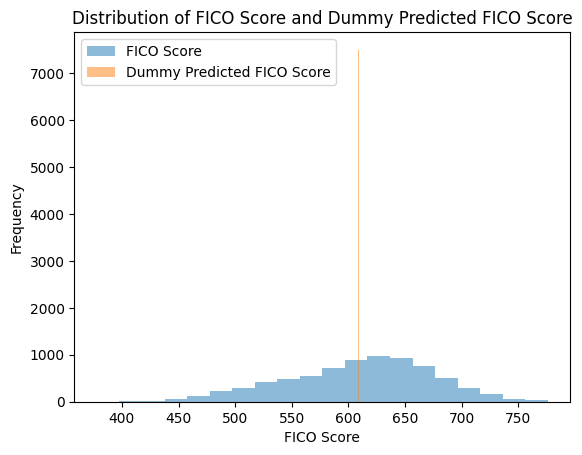

In [159]:
plt.hist(df['FICO Score'], bins=20, alpha=0.5, label='FICO Score')
plt.hist(df['Dummy Predicted FICO Score'], bins=20, alpha=0.5, label='Dummy Predicted FICO Score')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('Distribution of FICO Score and Dummy Predicted FICO Score')
plt.legend()
plt.show()

### Comparing FICO score ranges

The stakeholder does not want the absolute % deviation between the predicted and true FICO scores in each range to exceed 5%.

Calculate the amount of loans in each of the 5 FICO Score ranges based on the dummy model's predictions.

**What is the absolute % difference between the Predicted and True FICO scores in the Fair (580-669) rage?**

a) 100% b) 90% c) 80%

In [ ]:
df['Dummy Predicted FICO Score Range'] = pd.cut(df['Dummy Predicted FICO Score'], bins=[300, 579, 669, 739, 799, 850], labels=['Poor (300-579)', 'Fair (580-669)', 'Good (670-739)', 'Very Good (740-799)', 'Exceptional (800-850)'])
true_fico_range = df['FICO_true_range'].value_counts().sort_index()
pred_fico_range = df['Dummy Predicted FICO Score Range'].value_counts().sort_index()
diff = (pred_fico_range - true_fico_range) / true_fico_range * 100
diff = diff.rename('% difference between True and Predicted FICO Score Ranges')
diff

Dummy Predicted FICO Score Range
Poor (300-579)          -100.000000
Fair (580-669)            90.742625
Good (670-739)          -100.000000
Very Good (740-799)     -100.000000
Exceptional (800-850)           NaN
Name: \% difference between True and Predicted FICO Score Ranges, dtype: float64

### Calculating Expected Loss and Provision Ratio

#### Going from Credit Score to Probability of Default

Next, our stakeholder would like to know what is the Expected Loss and whether we follow the regulatory requirements in terms of reserves.

FICO scores and Probability of Default have an inverse relationship. The higher the FICO score the lower the probability of default, and this is logical - if we are a good borrower, we'd have a high FICO score and a lower probability of default because we are more likely to repay our loan. 

In reality, a bank may estimate it's internal FICO scores by first making a PD model and using the model's coefficients to calculate the PD scores, but for simplicity we do just take the FICO scores as a given and turn that into PDs. PD is important as it is one of the components to calculate Expected Loss.

Banks are required to keep a certain amount of their money in reserves for liquidity purposes, ensuring they have enough funds on hand to meet withdrawal demands and cover short-term liabilities. This reserve requirement helps maintain financial stability and prevents bank runs, where too many depositors attempt to withdraw funds at once, which could lead to the bank's insolvency.

In this example, we will assume that a bank is required by law to keep 8% of its loan portfolio as reserves.

This ratio is calculated as `Expected Loss / Total Amount of Loans Provided`. The denominator is easy to get, but we need to do some calculations to get the numerator.

`Expected Loss = Probability of Default * Loss Given Default * Exposure at Default`

EAD refers to the total value exposed to loss at the time of a borrower's default, and LGD represents the portion of the loan that is expected to be lost if the borrower defaults. Normally, in addition to a PD model, it has an LGD and EAD models, but in our case we will calculate those values from our data for simplicity.

Learning more about LGD and EAD is outside the scope of this notebook, so the calculation is provided for you in the `calculate_el` function.

In [ ]:
def credit_score_to_pd(credit_score_col: pd.Series):
    """ Convert credit score to probability of default """
    max_sum_coef = 5.208850778624095
    min_sum_coef = -2.465932685170253
    min_score = 300
    max_score = 850

    sum_coef_from_score = ((credit_score_col - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
    y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)

    return y_hat_proba_from_score

def calculate_el(df: pd.DataFrame, fico_col: str, return_sum: bool=False):
    """ Calculate expected loss """
    df_el = df.copy()
    df_el['RR'] = df_el['recoveries'] / df_el['funded_amnt']
    df_el['RR'] = df_el['RR'].clip(0, 1)
    df_el['LGD'] =  1 - df_el['RR']
    df_el['CCF'] = (df_el['funded_amnt'] - df_el['total_rec_prncp']) / df_el['funded_amnt']
    df_el['CCF'] = df_el['CCF'].clip(0, 1)
    df_el['EAD'] = df_el['funded_amnt'] * df_el['CCF']
    df_el['PD'] = credit_score_to_pd(df_el[fico_col])
    df_el['EL'] = df_el['PD'] * df_el['LGD'] * df_el['EAD']

    return df_el['EL'].sum() if return_sum else df_el

### Comparing Expected Losses

Calculate the EL given the true FICO scores and the EL given the FICO scores from our model.

**Compared to the EL based on the True FICO scores, is our model too conservative or too optimistic?**

* conservative - predicting a higher probability of default, leading to a more cautious approach (and higher expected loss)
* optimistic - predicting a lower probability of default, potentially underestimating credit risk (and lower expected loss)

a) conservative b) optimistic


In [199]:
model_el = calculate_el(df, 'Dummy Predicted FICO Score', return_sum=True)

print(f"Model EL: ${model_el:,.2f}")

Model EL: $9,909,298.07


### Are we following the law?

Double-check to make sure the Expected Loss to Total Amount of Loans Provided ratio given the true FICO scores is above the 8% required by regulators.

**Is the ratio using the Model FICO scores higher or lower than the ratio using the True FICO scores?**

a) higher b) lower

*Tip: The Total Amount of Loans provided can be calculated using the `funded_amnt` variable*

In [200]:
model_reserve_ratio = model_el / df['funded_amnt'].sum()

print(f"Model Reserve Ratio: {model_reserve_ratio:.2%}")

Model Reserve Ratio: 10.83%


## Recap on our metrics of interest to our stakeholder

- The ratio of overshot FICO scores outside the 5% margin should be below 0.5% (implying our models do not overestimate borrowers' repayability)
- % of loans for which the FICO score is outside a 5% margin difference from the truth should be preferably 0% (signifying our model predicts FICO scores closely to the True values)
- The stakeholder does not want the deviation between the true and predicted FICO scores in each range to exceed 5%
- Expected Loss $ - the lower the better, and Reserve ratio % - above the regulatory minimum of 8% (we need to follow the law)

Given our `DummyRegressor` model, the current metrics are, respectively:

- 67.23%
- 64.20%
- Every range's difference is more than 5%, except the Exceptional (800-850) range where we don't have any loans
- $9,909,298.07 and 10.83%

The current model is not satisfactory as it fails on 3 of the metrics of interest, and the stakeholder has asked you to build a model and report its performance based on the above metrics. 

## Now let's try to make a model that is able to predict FICO scores better, and evaluate it based on the above two metrics of interest

In [201]:
from skrub import TableVectorizer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
np.random.seed(42)

X_hgbr = df.drop(['FICO Score'], axis=1)
y_hgbr = df['FICO Score']

X_train_hgbr, X_test_hgbr, y_train_hgbr, y_test_hgbr = train_test_split(X_hgbr, y_hgbr, test_size=0.2, random_state=42)

model_hgbr = make_pipeline(TableVectorizer(), HistGradientBoostingRegressor(random_state=42))
model_hgbr.fit(X_train_hgbr, y_train_hgbr)

model_rmse_hgbr = np.sqrt(mean_squared_error(y_test_hgbr, model_hgbr.predict(X_test_hgbr)))
model_rmse_hgbr

0.787020993218783

### Are we overshooting FICO scores by more than 5%

In [202]:
overshot_count_hgbr = (df['FICO Score HGBR'] > df['FICO Score']).sum()
overshot_outside_margin_hgbr = ((df['FICO Score HGBR'] > df['FICO Score']) & (np.abs(df['FICO Score HGBR'] - df['FICO Score']) / df['FICO Score'] > 0.05)).sum()
overshot_outside_margin_percent_hgbr = overshot_outside_margin_hgbr / overshot_count_hgbr * 100
print(f'Percentage of loans that the new model overshot by more than 5%: {overshot_outside_margin_percent_hgbr:.2f}%')

Percentage of loans that the new model overshot by more than 5%: 0.03%


### Percentage of loans outside the 5% margin

In [203]:
df['FICO Score HGBR'] = model_hgbr.predict(X_hgbr)

ratio_hgbr = perc_loans_outside_margin(df, 'FICO Score HGBR')
ratio_hgbr

0.013333333333333334

### Compare the distributions of True and Predicted FICO socres

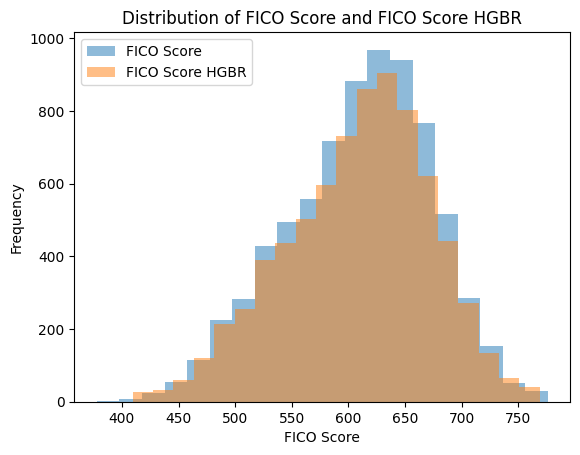

In [204]:
plt.hist(df['FICO Score'], bins=20, alpha=0.5, label='FICO Score')
plt.hist(df['FICO Score HGBR'], bins=20, alpha=0.5, label='FICO Score HGBR')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('Distribution of FICO Score and FICO Score HGBR')
plt.legend()
plt.show()

### Comparing FICO score ranges (no absolute % difference should be larger than 5%)

In [205]:
df['HGBR FICO Score Range'] = pd.cut(df['FICO Score HGBR'], bins=[300, 579, 669, 739, 799, 850], labels=['Poor (300-579)', 'Fair (580-669)', 'Good (670-739)', 'Very Good (740-799)', 'Exceptional (800-850)'])
true_fico_range_hgbr = df['FICO_true_range'].value_counts().sort_index()
pred_fico_range_hgbr = df['HGBR FICO Score Range'].value_counts().sort_index()
diff_hgbr = (pred_fico_range_hgbr - true_fico_range_hgbr) / true_fico_range_hgbr * 100
diff_hgbr = diff_hgbr.rename('% difference between True and Predicted FICO Score Ranges')
diff_hgbr

HGBR FICO Score Range
Poor (300-579)          -0.610288
Fair (580-669)           0.025432
Good (670-739)           0.829187
Very Good (740-799)      4.411765
Exceptional (800-850)         NaN
Name: % difference between True and Predicted FICO Score Ranges, dtype: float64

### Comparing Expected Losses

In [206]:
hgbr_el = calculate_el(df, 'FICO Score HGBR', return_sum=True)

print(f"HGBR EL: ${hgbr_el:,.2f}")

HGBR EL: $7,871,616.41


In [207]:
hgbr_reserve_ratio = hgbr_el / df['funded_amnt'].sum()

print(f"Model Reserve Ratio: {hgbr_reserve_ratio:.2%}")

Model Reserve Ratio: 8.61%


## Report to the stakeholder

This report compares the performance of the current and challenger models used to determine the required loan reserve. Key metrics, including the accuracy of FICO score estimations, expected loss, and reserve ratio, are analyzed to assess improvements made by the challenger model.

## Key Metrics

| Metric                                      | Model 1 (Current) | Model 2 (Challenger) |
|---------------------------------------------|--------------------|-----------------------|
| **% of loans for which the FICO score is overshot by more than 5%**              | 67.23%            | 0.03%                |
| **% of loans outside the required 5% margin**            | 64.20%            | 0.013333             |
| **Expected Loss**                           | $9,909,298.07     | $7,871,616.41        |
| **Model Reserve Ratio**                     | 10.83%            | 8.61%                |

Regulators require the bank to keep a minimum of 8% of our loan portfolio as reserves.

### FICO Score Range Comparison
This table shows the percentage difference in FICO score predictions by range. Values outside the ±5% range are areas of concern, with Model 2 demonstrating significant improvement over Model 1 in accuracy.

| FICO Score Range       | Model 1 Difference (%) | Model 2 Difference (%) |
|------------------------|------------------------|------------------------|
| **Poor (300-579)**     | -100.00            | -0.61             |
| **Fair (580-669)**     | 90.74              | 0.03              |
| **Good (670-739)**     | -100.00            | 0.83              |
| **Very Good (740-799)**| -100.00            | 4.41             |
| **Exceptional (800-850)** | NaN                | NaN                   |

## Analysis

1. **Accuracy Improvement**: Model 2 significantly reduces the percentage of loans overshot by more than 5%, bringing it down to just 0.03% compared to Model 1's 67.23%. Additionally, Model 2 maintains a high level of accuracy across all FICO score ranges, with no difference exceeding ±5%.

2. **Expected Loss Reduction**: Model 2 decreases the expected loss from $9.91M to $7.87M, an improvement that could yield substantial financial benefits.

3. **Reserve Ratio Compliance**: Model 2's reserve ratio of 8.61% meets the regulatory requirement of keeping at least 8% in reserves and is closer to this minimum requirement than Model 1's 10.83%, optimizing capital allocation. 

## Conclusion
The challenger model (Model 2) demonstrates clear advantages in prediction accuracy, financial efficiency, and regulatory compliance. Transitioning to Model 2 is recommended to optimize reserve allocation while maintaining adherence to regulatory requirements.